<a href="https://colab.research.google.com/github/leoferro/Clusteriza-o_cidades/blob/main/Clusteriza%C3%A7%C3%A3o_de_cidades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização de cidades

Testes práticos utilizando os conceitos de clusterização

In [122]:
import requests

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Criação da função que pega a variavel da pesquisa e retorna um dataframe apenas com as colunas relevantes para seu resultado

In [151]:
def get_variable(numero_variavel: str) -> pd.DataFrame:
  '''
      A partir do numero da variavel realiza um request na API do IBGE
      Resgata o nome da variavel e seus resultados por cidade
      Converte em um dataframe e cria suas colunas
      Retorna esse dataframe apenas com as colunas
      ["cidade", "id_cidade", "{variavel_nome}"]
  '''

  req = requests.get(f'https://servicodados.ibge.gov.br/api/v3/agregados/8418/periodos/2019/variaveis/{numero_variavel}?localidades=N6[all]')

  res = req.json()[0]

  variavel_nome    = res['variavel']
  serie_resultados = res['resultados'][0]['series']

  df = pd.DataFrame(serie_resultados)


  df['cidade']        = df['localidade'].apply(lambda x : x['nome'])
  df['id_cidade']     = df['localidade'].apply(lambda x : x['id'])

  df[variavel_nome] = df['serie'].apply(lambda x: float(x['2019']))

  df.drop(['serie', 'localidade'], axis=1, inplace=True)

  return df

Utilizando a função acima para iterar na lista dos ids das variáveis da api

In [152]:
vars_ids = [str(x) for x in range (12747, 12755)]

dfs = []

for var_id in vars_ids:
  dfs.append(get_variable(var_id))

Join dos dataframes a partir da cidade

In [153]:
df = dfs.pop()

for df4join in dfs:
  df = df.merge(df4join, how = 'outer', on=['cidade','id_cidade'])

display(df.shape)
display(df.head())

(5570, 10)

,cidade,id_cidade,Vazios remanescentes,Áreas urbanizadas densas,Áreas urbanizadas pouco densas,Total de áreas urbanizadas,Loteamento vazio,Área total mapeada,Outros equipamentos urbanos,Vazios intraurbanos
0,Alta Floresta D'Oeste - RO,1100015,0.0,5.12,1.33,6.46,0.13,6.58,0.11,0.00
1,Ariquemes - RO,1100023,0.0,30.28,2.98,33.26,0.91,34.17,2.98,0.58
2,Cabixi - RO,1100031,0.0,1.36,0.88,2.24,0.00,2.24,0.06,0.00
3,Cacoal - RO,1100049,0.0,24.60,3.45,28.04,0.97,29.01,3.17,0.00
4,Cerejeiras - RO,1100056,0.0,5.43,0.88,6.31,0.38,6.70,0.22,0.00


### Criando mais features

In [156]:
df['estado']  = df['cidade'].str[-2:]
df['cidade']  = df['cidade'].str[:-5]

regioes = {
    '1':'norte',
    '2':'nordeste',
    '3':'sudeste',
    '4':'sul',
    '5':'centroeste',
}

df['regioes'] = df['id_cidade'].str[:1].map(regioes)


In [157]:
df[['regioes', 'estado']].value_counts()

regioes     estado
sudeste     MG        853
            SP        645
sul         RS        497
nordeste    BA        417
sul         PR        399
            SC        295
centroeste  GO        246
nordeste    PI        224
            PB        223
            MA        217
            PE        185
            CE        184
            RN        167
norte       PA        144
centroeste  MT        141
norte       TO        139
nordeste    AL        102
sudeste     RJ         92
centroeste  MS         79
sudeste     ES         78
nordeste    SE         75
norte       AM         62
            RO         52
            AC         22
            AP         16
            RR         15
centroeste  DF          1
dtype: int64

## Primeiras Analises

Não Há valores Nulos

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5569
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cidade                          5570 non-null   object 
 1   id_cidade                       5570 non-null   object 
 2   Vazios remanescentes            5570 non-null   float64
 3   Áreas urbanizadas densas        5570 non-null   float64
 4   Áreas urbanizadas pouco densas  5570 non-null   float64
 5   Total de áreas urbanizadas      5570 non-null   float64
 6   Loteamento vazio                5570 non-null   float64
 7   Área total mapeada              5570 non-null   float64
 8   Outros equipamentos urbanos     5570 non-null   float64
 9   Vazios intraurbanos             5570 non-null   float64
 10  estado                          5570 non-null   object 
 11  regioes                         5570 non-null   object 
dtypes: float64(8), object(4)
memory us

Tanto os "Vazios remanescentes" quanto os "Vazios interurbanos" mais de 75% dos dados são 0.

"Loteamento Vazio" e "Outros equipamentos urbanod" temos pelo menos 25% como 0

As outras 3 variáveis apresentam desvio padrão proximo e maximo proximo, endo necessário mais estudo para ver se existe alguma correlação entre elas.

In [159]:
df.describe()

,Vazios remanescentes,Áreas urbanizadas densas,Áreas urbanizadas pouco densas,Total de áreas urbanizadas,Loteamento vazio,Área total mapeada,Outros equipamentos urbanos,Vazios intraurbanos
count,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000,5570.000000
mean,0.003336,6.600768,1.647785,8.248522,0.378452,8.626977,0.410776,0.066513
std,0.058862,22.835446,3.250011,24.555514,1.050450,24.915963,1.276400,0.504354
min,0.000000,0.000000,0.000000,0.120000,0.000000,0.120000,0.000000,0.000000
25%,0.000000,1.022500,0.170000,1.420000,0.000000,1.470000,0.000000,0.000000
50%,0.000000,2.090000,0.610000,2.940000,0.050000,3.100000,0.040000,0.000000
75%,0.000000,4.880000,1.690000,6.820000,0.300000,7.330000,0.290000,0.000000
max,3.470000,895.360000,52.050000,914.560000,17.510000,914.730000,32.940000,19.410000


### Analise visual

"Total de área urbanizadas", "Área total Mapeada", "Áreas urbanizadas densas" possuem uma correlação linear forte aparentemente.

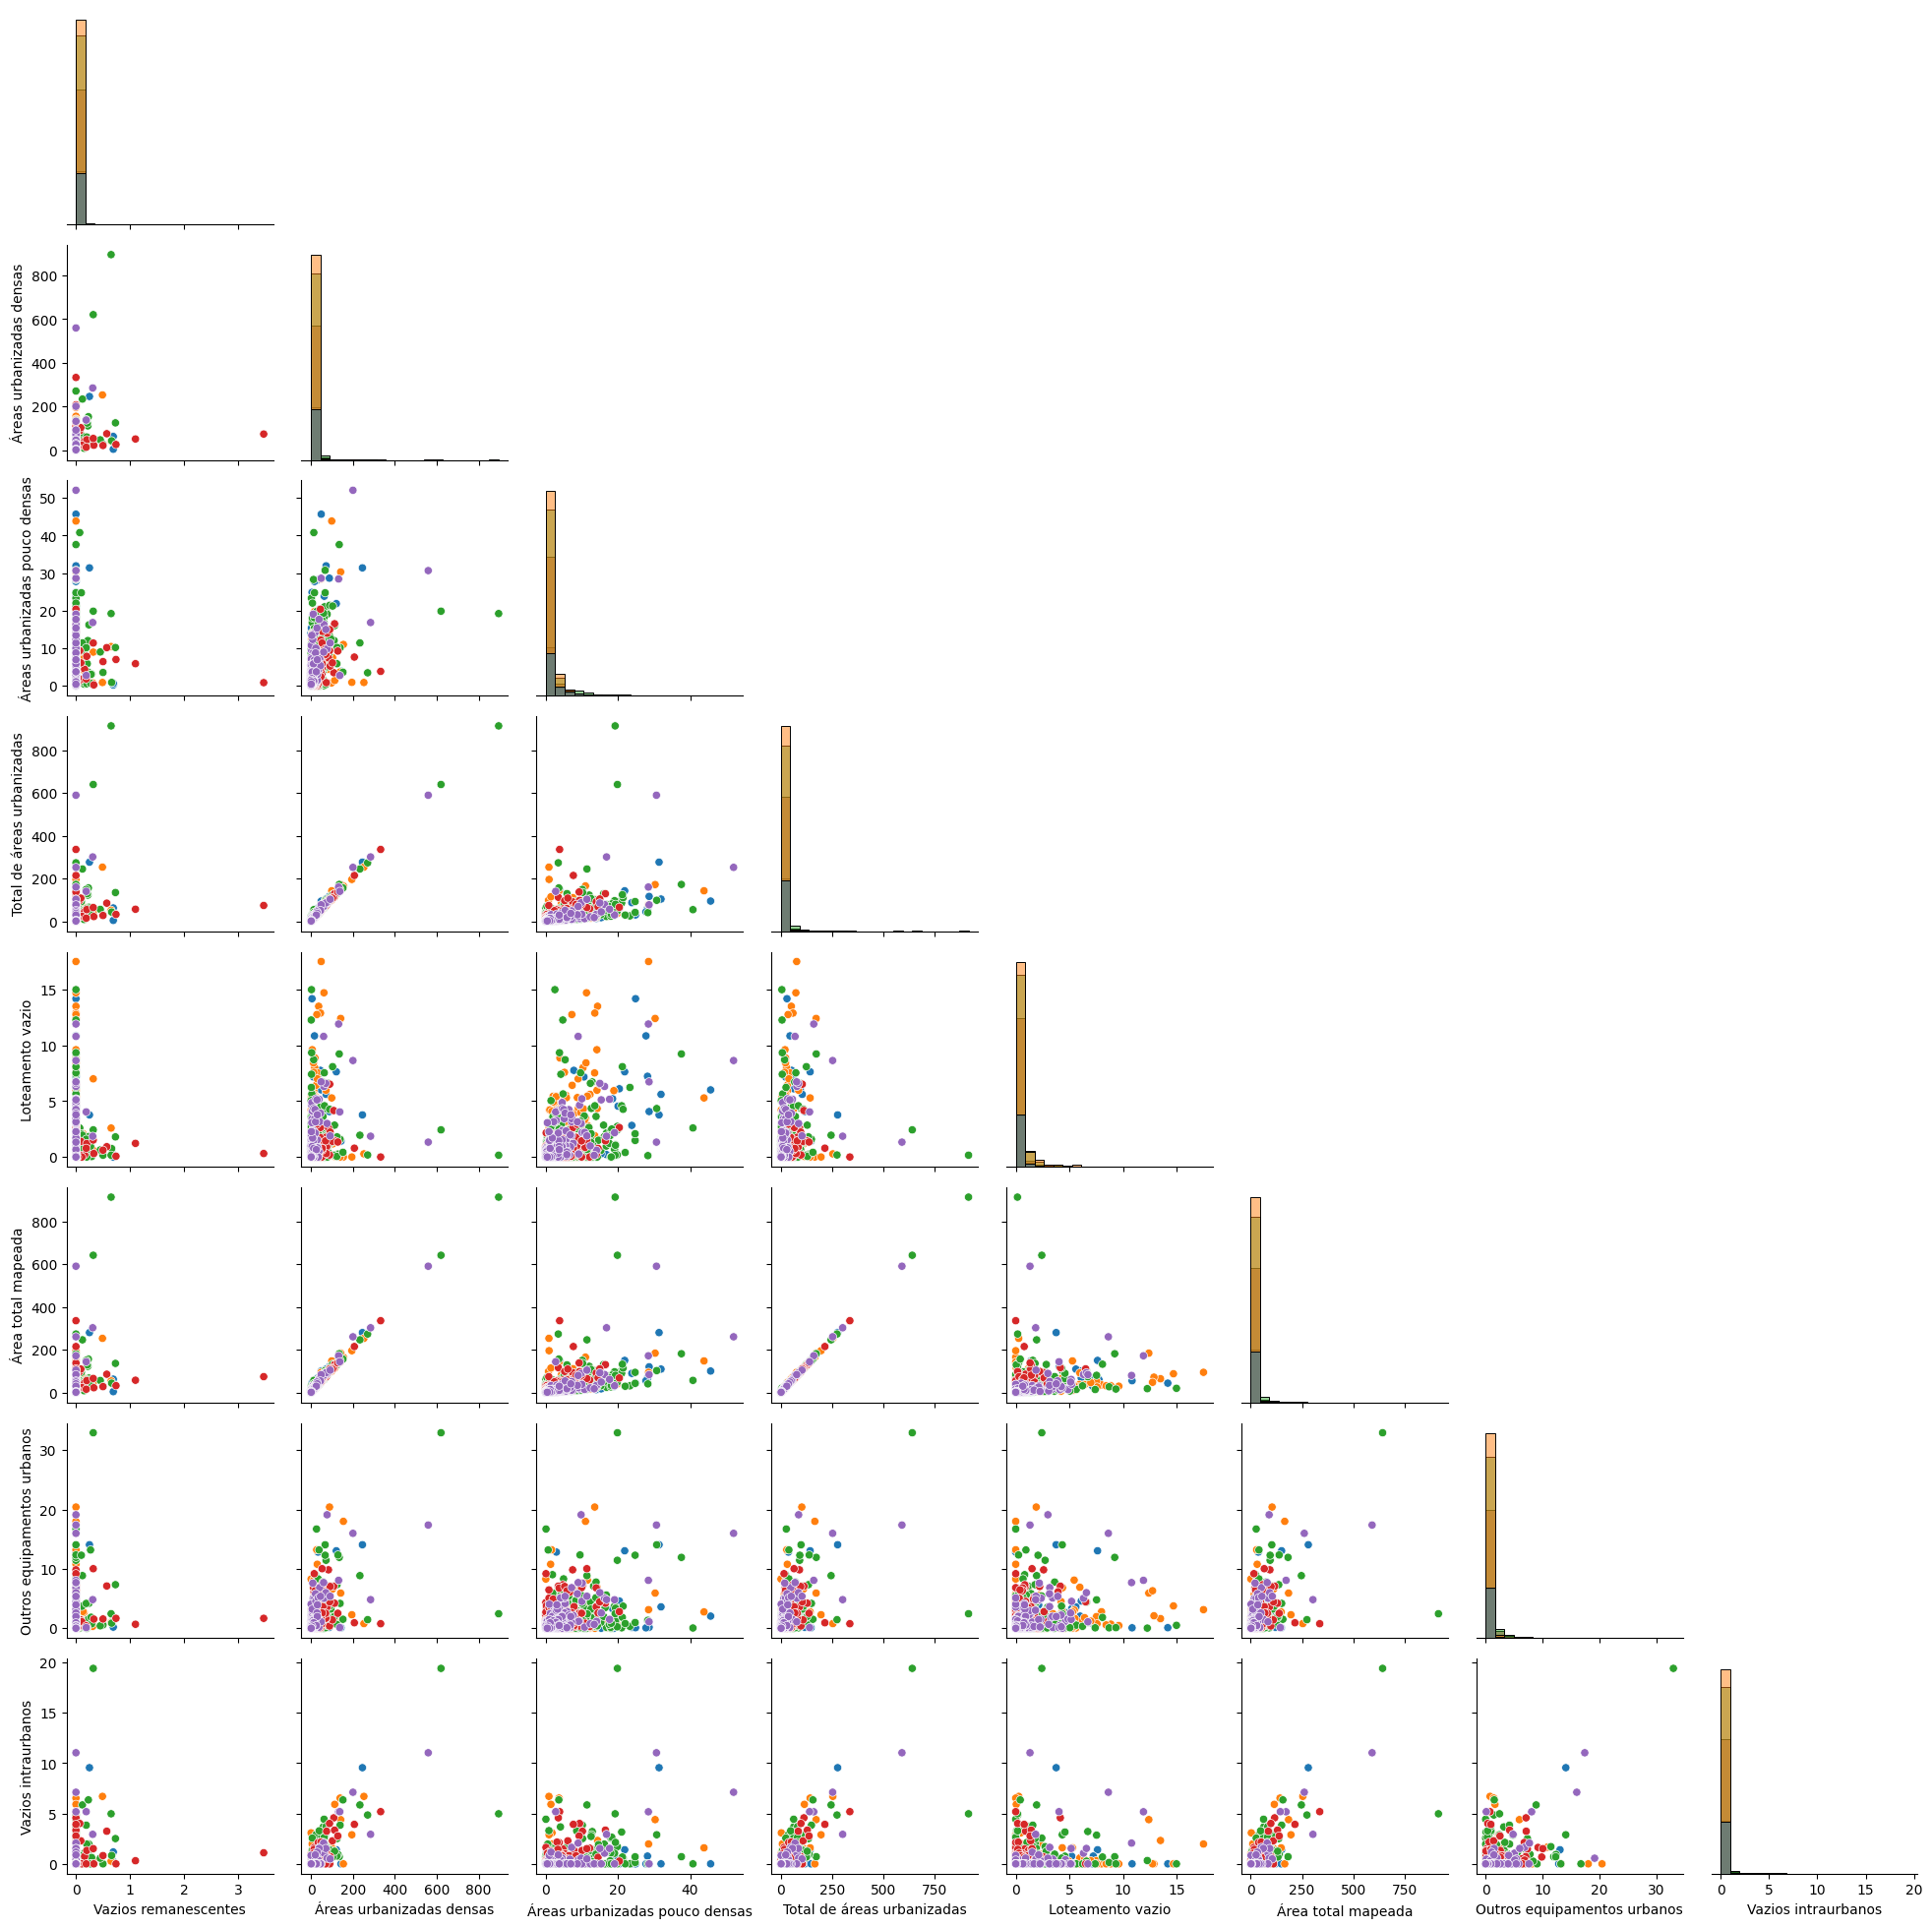

In [160]:
g = sns.PairGrid(df, diag_sharey=False, corner=True, hue= 'regioes')
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, bins = 20)

Transformação em algumas variáveis

<Axes: xlabel='% de areas urbanizadas mapeadas', ylabel='% de areas urbanizadas densas em areas urbanizadas'>

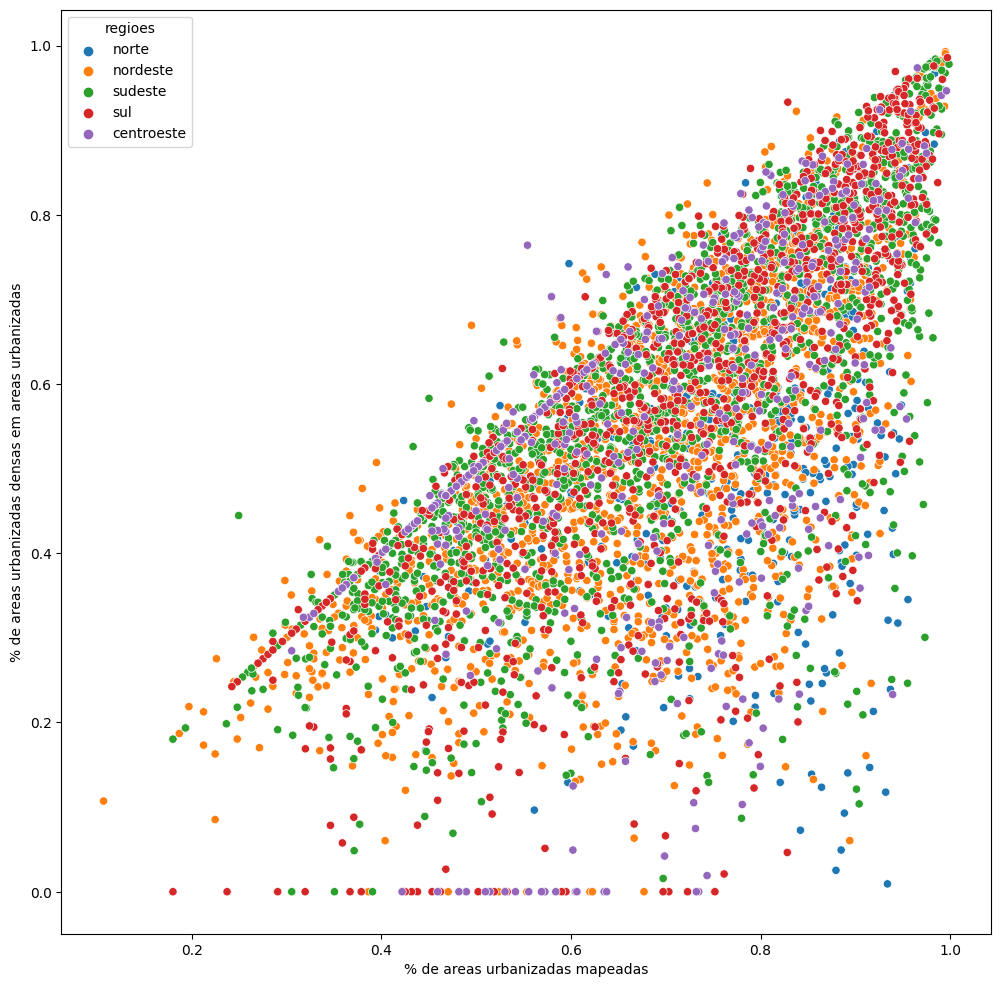

In [162]:
df['% de areas urbanizadas mapeadas']                    =  df.iloc[:,5] /(df.iloc[:,7]+1)
df['% de areas urbanizadas densas em areas urbanizadas'] =  df.iloc[:,3] /(df.iloc[:,5]+1)

plt.figure(figsize=(12,12))
sns.scatterplot(data = df, x = '% de areas urbanizadas mapeadas', y ='% de areas urbanizadas densas em areas urbanizadas', hue = 'regioes')

<Axes: xlabel='% de areas urbanizadas densas em areas urbanizadas', ylabel='Count'>

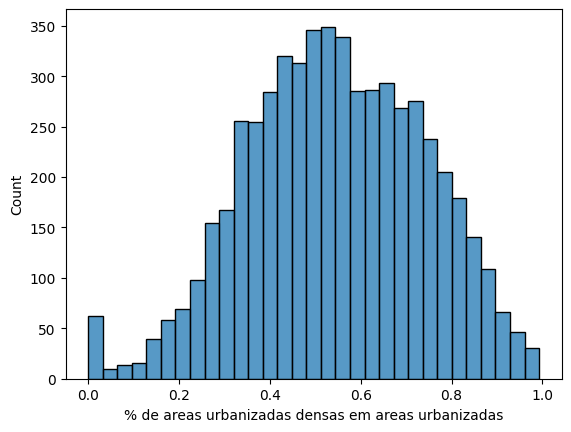

In [166]:
sns.histplot(df.iloc[:,-1])

<Axes: xlabel='% de areas urbanizadas mapeadas', ylabel='Count'>

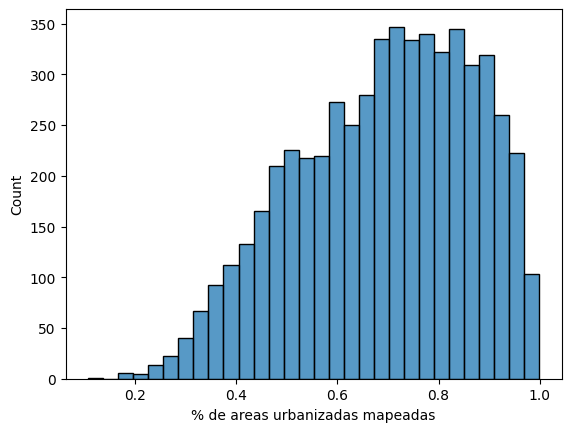

In [167]:
sns.histplot(df.iloc[:,-2])

Retirar colunas trasnformadas

In [ ]:
df.drop(df.iloc[[0],[3,5,7]].columns, axis = 1, inplace=True)